## **Shapley value**

The KernelExplainer builds a weighted linear regression by using your data, your predictions, and whatever function that predicts the predicted values. It computes the variable importance values based on the Shapley values from game theory, and the coefficients from a local linear regression.

This gives us:

* **Global interpretability**: contribution of each variable over the target in general.


* **Local interpretability**: for an individual observation how each variable contribute to this.

**Disadvantages**

* Long running time. 
* Not optimized for all models, like for example (knn)

**Recomendations**

* For **tree-based machine learning model**, you should use the tree explainer **TreeExplainer()** that has been optimized to render fast results for XGBoost, LightGBM, CatBoost, scikit-learn and pyspark tree models. 
* For **deep learning model**, use the deep learning explainer **DeepExplainer()**. 
* For any other algorithm, you can use **KernelExplainer()**.

## **LOAD PACKAGES**

In [1]:
import pandas as pd
import numpy as np
from numpy.core.umath_tests import inner1d
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is 'quality'.

/Users/erikapat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  This is separate from the ipykernel package so we can avoid doing imports until


## **Wine Quality data**
Here, we use the red wine quality data to do the analysis. The target value of this dataset is the quality rating from low to high (0–10). The input variables are the content of each wine sample including fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates and alcohol. There are 1,599 wine samples.

In [2]:
df = pd.read_csv('data/winequality-red.csv', sep = ';') # Load the data
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
Y = df['quality']
X =  df[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar','chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## **Random forest + TreeExplainer()**

We will use a rf model along with **TreeExplainer()**.

[0.02771784 0.14608857 0.0098873  0.03979135 0.03834853 0.02349039
 0.07114265 0.01940386 0.04327445 0.20548462 0.37537044]


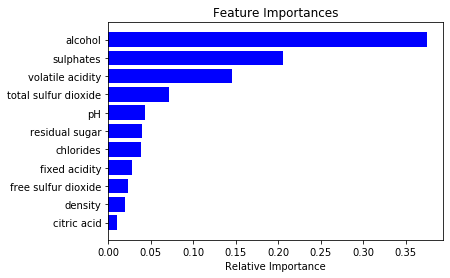

In [4]:
rf = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf.fit(X_train, Y_train)  
print(rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## **SHAPLEY MODULE**

In [5]:
# INSTALL SHAPLEY VALUES
#!pip install shap
#conda install -c conda-forge shap

In [6]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

/Users/erikapat/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, defaultdict


## **TreeExplainer(): Variable Importance Plot — Global Interpretability**

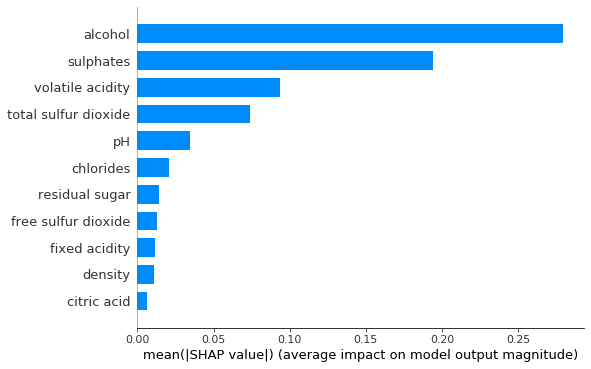

In [7]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## **The summary plot**
This plot has loaded information. It shows the positive and negative relationships of the predictors with the target variable. It looks dotty because it is made of all the dots in the train data. 

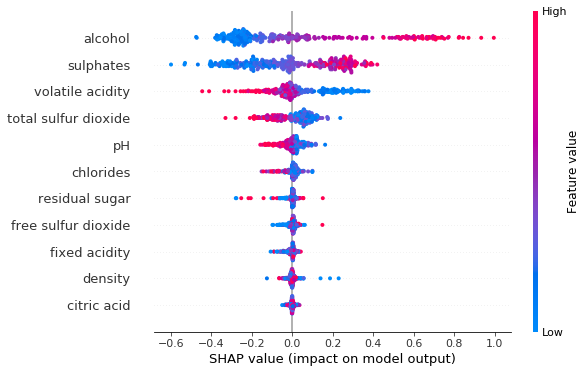

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

* **Feature importance**: Variables are ranked in descending order.
* **Impact**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
* **Original value:** Color shows whether that variable is high (in red) or low (in blue) for that observation.
* **Correlation:** A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say “volatile acidity” is negatively correlated with the target variable.

## **The dependence plot**

It shows the marginal effect that one or two variables have on the predicted outcome. It tells whether the relationship between the target and the variable is linear, monotonic or more complex. Suppose we want to get the dependence plot of “alcohol”. The following plot shows that there is an approximately linear and positive trend between “alcohol” and the target variable, and “alcohol” interacts with “sulphates” frequently.

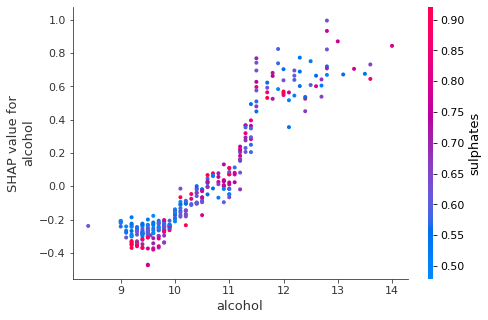

In [9]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("alcohol", shap_values, X_test)

The plot below shows there exists an approximately linear but negative relationship between `volatile acidity` and the target variable. This negative relationship is already demonstrated in the variable importance plot 

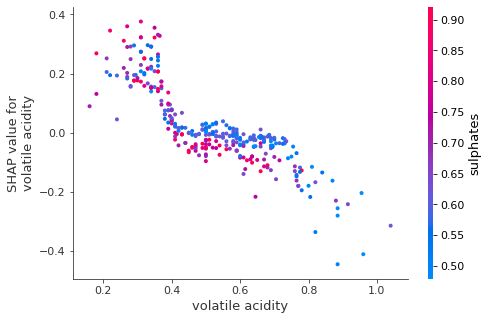

In [21]:
shap.dependence_plot("volatile acidity", shap_values, X_test)

## **The individual force plot**

You can produce a very elegant plot for each observation called the force plot. I arbitrarily chose the 10th observation of the X_test data. Below are the average values of X_test, and the values of the 10th observation.

In [10]:
X_test.mean()

fixed acidity            8.248750
volatile acidity         0.519109
citric acid              0.266156
residual sugar           2.481406
chlorides                0.089234
free sulfur dioxide     15.243750
total sulfur dioxide    43.884375
density                  0.996704
pH                       3.316250
sulphates                0.654438
alcohol                 10.458906
dtype: float64

In [11]:
X_test.iloc[10,:]

fixed acidity            8.60000
volatile acidity         0.52000
citric acid              0.38000
residual sugar           1.50000
chlorides                0.09600
free sulfur dioxide      5.00000
total sulfur dioxide    18.00000
density                  0.99666
pH                       3.20000
sulphates                0.52000
alcohol                  9.40000
Name: 1099, dtype: float64

In [12]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap_values and X_test should have the same subset
shap.force_plot(explainer.expected_value, shap_values[10,:], X_test.iloc[10,:])

In [13]:
Y_test.mean()

5.59375

* The **output value** is the prediction for that observation (the prediction for this observation is 5.11).
* The **base value**: The original paper explains that the base value E(y_hat) is “the value that would be predicted if we did not know any features for the current output.” In other words, it is **the mean prediction**, or mean(yhat). You may wonder why it is 5.634. This is because the mean prediction of Y_test is 5.634. You can test it out by Y_test.mean() which produces 5.634.
* **Red/blue**: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.
* **Alcohol:** has positive impact on the quality rating. The alcohol of this wine is 9.4 which is lower than the average value 10.48. So it pushes the prediction to the left.
* **Total sulfur dioxide:** is positively related to the quality rating. A higher-than-the-average sulfur dioxide (= 18 > 14.98) pushes the prediction to the right.
* The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the **model's expected value like a linear model's effects are relative to the intercept.**

## **The collective force plot**

Each observation has its own force plot. If all the force plots are combined, rotated 90 degrees and stacked horizontally, we get the force plot of the entire data X_test 

In [14]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)

## **KernelExplainer()**
The function KernelExplainer() below performs a local regression by taking the prediction method rf.predict and the data that you want to perform the SHAP values. Here I use the test dataset X_test which has 160 observations. This step can take a while

## **ALTERNATIVE: LIME**

In [15]:
import lime
import lime.lime_tabular

In [16]:
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(df.values,  
                              feature_names=df.columns.values.tolist(), 
                              class_names=['quality'], 
                              categorical_features=X.columns, 
                              verbose=True,  
                              mode='regression')

In [17]:
len(X.columns)

11

In [18]:
X_test.values[0]

array([10.8   ,  0.47  ,  0.43  ,  2.1   ,  0.171 , 27.    , 66.    ,
        0.9982,  3.17  ,  0.76  , 10.8   ])

In [19]:
exp = explainer.explain_instance(X_test.values[0], rf.predict, num_features=5)
exp.show_in_notebook(show_table=True)

IndexError: index 11 is out of bounds for axis 0 with size 11

## **OTHER PACKAGES**

Another packages are **iml (Interpretable Machine Learning)** and **DALEX (Descriptive mAchine Learning EXplanations)** that contains various explainers that help to understand the link between input variables and model output.

## **REFERENCES**

* https://github.com/slundberg/shap